In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import pandas as pd
import missingno as msno
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit, LeaveOneOut
from sklearn import linear_model
from sklearn.tree import _tree, export_graphviz, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.externals import joblib
import graphviz
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [2]:
df = pd.read_excel(os.path.join('rawdata', 'Aeon Water Data 10-9-17.xlsx'))
cols = df.columns.tolist()
cols = [col.lower() for col in cols]
df.columns = cols
print('Size of the dataframe is:  {}'.format(df.shape))
print('Test for null values:  {}'.format(df.isnull().any().any()))
df.dtypes

Size of the dataframe is:  (4391, 62)
Test for null values:  True


yardi building name                      object
match building name                      object
month                                    object
year                                      int64
month start date                         object
total # bedrooms  in building             int64
gallons per bedroom per month           float64
gallons per building per month          float64
year built/gut rehabbed                   int64
single family?                           object
single family building type              object
low-income housing                       object
predominant resident type                object
type of construction                     object
is there a basement?                     object
is basement finished & heated?           object
gross bldg sq ft                        float64
if multi-family sum of apt sq ft          int64
basement sq ft                            int64
# stories                               float64
if multi-family, # units                

## Visual Assessment Of Empty Rows

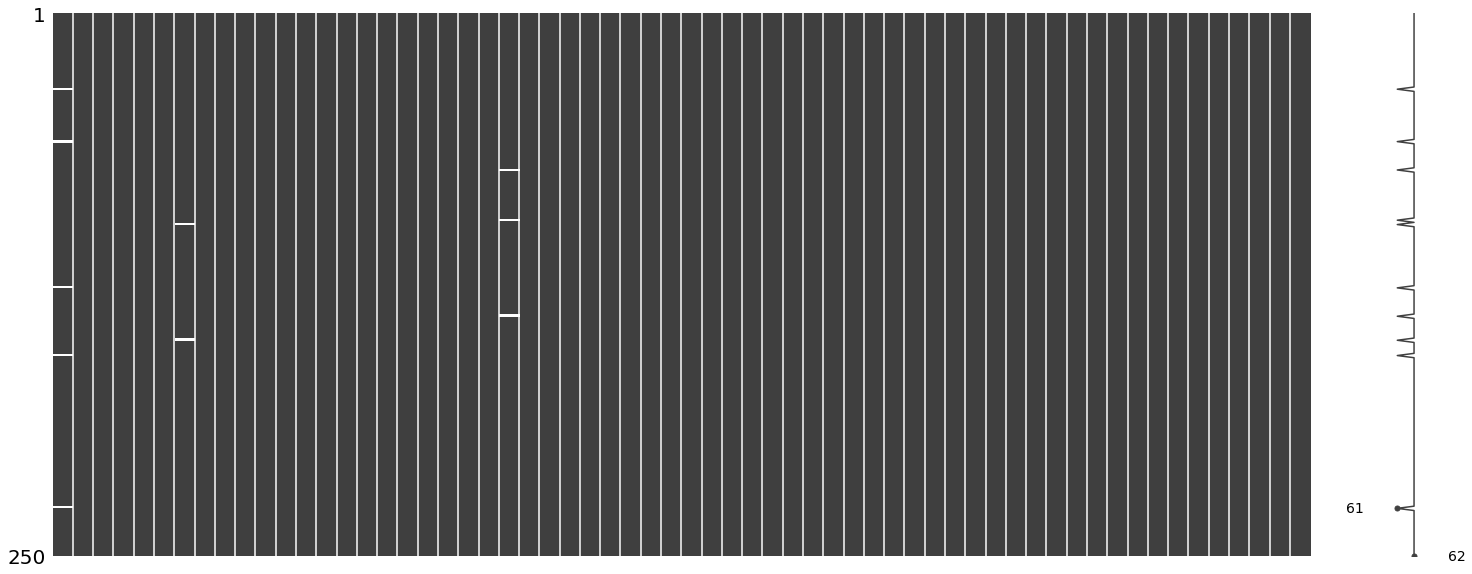

In [3]:
msno.matrix(df.sample(250))

In [4]:
# For the sake of expedient modeling, drop the rows that have missing values
print(df.loc[df.isnull().any(axis=1)].shape)
df = df.dropna()

(109, 62)


In [5]:
# Rename the target columns and calculate an age for each building

df.rename(columns={'gallons per building per month': 'target'}, inplace=True)
df = df.assign(bldg_age=df['year'] - df['year built/gut rehabbed'])

In [6]:
# Convert the yearly values to strings
df[['year', 'year built/gut rehabbed']] = df[
    ['year', 'year built/gut rehabbed']].astype(str)
numerical = df.loc[:, df.dtypes != 'object']
numerical.head()

total # bedrooms  in building  gallons per bedroom per month       target  \
0                             18                      1714.6111   30862.9998   
1                             61                      1291.0000   78751.0000   
2                             30                      3910.0000  117300.0000   
3                             52                      1705.8577   88704.6004   
4                             38                      1675.8105   63680.7990   

   gross bldg sq ft  if multi-family sum of apt sq ft  basement sq ft  \
0           18000.0                              9772            4500   
1           33124.0                             20790            7126   
2           19760.0                             12178            4940   
3           32467.0                             17316            6839   
4           16464.0                              9970               0   

   # stories  if multi-family, # units  # elevators  # of days in month  \
0        4.0                        18            0                  31   
1        3.0                        51            1                  31   
2        3.0                        30            0                  31   
3        5.0                        52            1                  31   
4        3.0                        38            0                  31   

   # of 0 bedroom units in building  # of 1 bedroom units in building  \
0                                 0                                18   
1                                59                                 2   
2                                26                                 4   
3                                52                                 0   
4                                38                                 0   

   # of 2 bedroom units in building  # of 3 bedroom units in building  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   # of 4 bedroom units in building  # of 5 bedroom units in building  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   0 bedrooms - days vacant  1 bedrooms days vacant  2 bedrooms days vacant  \
0                         0                       0                       0   
1                       261                       0                       0   
2                        48                      33                       0   
3                       277                       0                       0   
4                        48                       0                       0   

   3 bedrooms days vacant  4 bedrooms days vacant  5 bedrooms days vacant  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   

   # of 0 bedrooms * days in month  # of 1 bedrooms * days in month  \
0                                0                              558   
1                             1829                               62   
2                              806                              124   
3                             1612                                0   
4                     

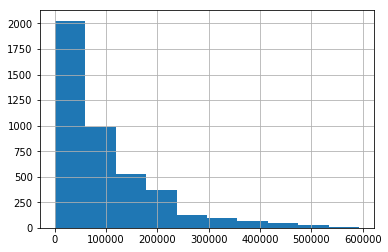

In [7]:
# Exploratory analysis of numerical values
numerical['target'].hist()

In [8]:
print('How many of the target values are zero?  {}'.format(numerical['target'].loc[numerical['target']==0].shape[0]))
print('Summarize the numerical data...')
numerical.describe()

How many of the target values are zero?  4
Summarize the numerical data...


total # bedrooms  in building  gallons per bedroom per month  \
count                    4282.000000                    4282.000000   
mean                       39.521018                    2564.315151   
std                        38.420322                    1230.624687   
min                         1.000000                       0.000000   
25%                         8.000000                    1823.724900   
50%                        26.000000                    2336.144050   
75%                        61.000000                    3000.991675   
max                       166.000000                   13112.000000   

              target  gross bldg sq ft  if multi-family sum of apt sq ft  \
count    4282.000000       4282.000000                       4282.000000   
mean    97258.865249      26473.133582                      18441.471042   
std    101705.207525      27822.270441                      19678.091189   
min         0.000000        853.000000                          0.000000   
25%     21234.975000       4310.000000                       3890.000000   
50%     66724.349800      17176.600000                      12500.000000   
75%    137072.730000      36000.000000                      26611.000000   
max    592877.000000     123355.000000                      83968.000000   

       basement sq ft    # stories  if multi-family, # units  # elevators  \
count     4282.000000  4282.000000                4282.00000  4282.000000   
mean      2718.327884     3.259038                  29.81574     0.385100   
std       3425.980027     1.760165                  30.53881     0.665141   
min          0.000000     1.000000                   0.00000     0.000000   
25%          0.000000     2.000000                   3.00000     0.000000   
50%       1224.000000     3.000000                  23.00000     0.000000   
75%       4554.000000     4.000000                  51.00000     1.000000   
max      18522.000000    13.000000                 122.00000     3.000000   

       # of days in month  # of 0 bedroom units in building  \
count         4282.000000                       4282.000000   
mean            30.426903                         10.985287   
std              0.842353                         20.740407   
min             28.000000                          0.000000   
25%             30.000000                          0.000000   
50%             31.000000                          0.000000   
75%             31.000000                         12.000000   
max             31.000000                         74.000000   

       # of 1 bedroom units in building  # of 2 bedroom units in building  \
count                       4282.000000                       4282.000000   
mean                          11.926670                          5.253153   
std                           21.176773                          9.615956   
min                            0.000000                          0.000000   
25%                            0.000000                          0.000000   
50%                            1.000000                          0.000000   
75%                           17.000000                          5.000000   
max                          100.000000                         44.000000   

       # of 3 bedroom units in building  # of 4 bedroom units in building  \
count                       4282.000000                       4282.000000   
mean                           1.768333                          0.183092   
std                            3.556669                          0.553694   
min                            0.000000                          0.000000   
25%                            0.000000                          0.000000   
50%                            0.000000                          0.000000   
75%                            2.000000                          0.000000   
max                           16.000000                          2.000000   

       # of 5 bedroom units in b

In [9]:
# Dropped the 5-Bedroom Vacant values because they are all zero
numerical = numerical.drop(['5 bedroom number of vacant units', '5 bedrooms days vacant'], axis=1)

## Visualization Of Spearman Correlation Coefficients

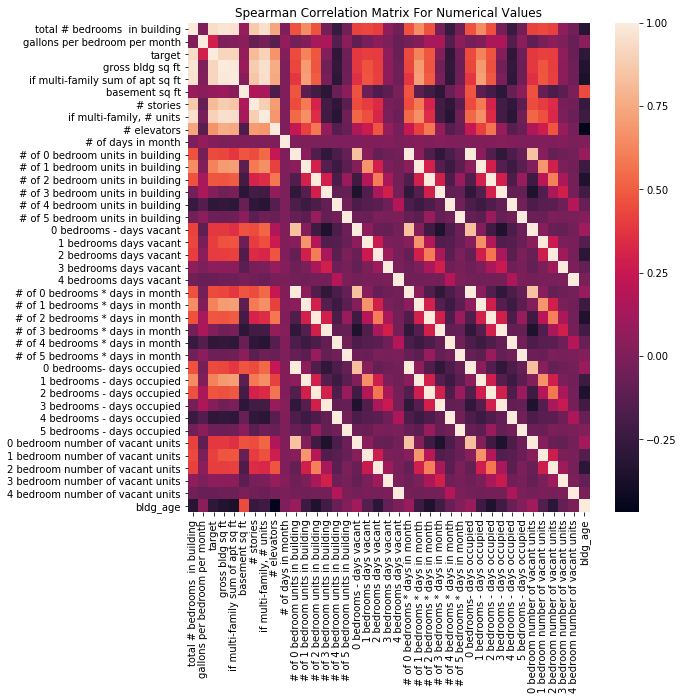

In [10]:
corrs = numerical.corr(method='spearman')
plt.subplots(figsize=(9, 9))
plt.title('Spearman Correlation Matrix For Numerical Values')
sns.heatmap(corrs)
plt.show()

In [11]:
print('Display a list of index-value pairs for the numerical values.  Used for slicing the data')
for i, j in enumerate(numerical.columns.tolist()):
    print('{}.  {}'.format(i, j))

Display a list of index-value pairs for the numerical values.  Used for slicing the data
0.  total # bedrooms  in building
1.  gallons per bedroom per month
2.  target
3.  gross bldg sq ft
4.  if multi-family sum of apt sq ft
5.  basement sq ft
6.  # stories
7.  if multi-family, # units
8.  # elevators
9.  # of days in month
10.  # of 0 bedroom units in building
11.  # of 1 bedroom units in building
12.  # of 2 bedroom units in building
13.  # of 3 bedroom units in building
14.  # of 4 bedroom units in building
15.  # of 5 bedroom units in building
16.  0 bedrooms - days vacant
17.  1 bedrooms days vacant
18.  2 bedrooms days vacant
19.  3 bedrooms days vacant
20.  4 bedrooms days vacant
21.  # of 0 bedrooms * days in month
22.  # of 1 bedrooms * days in month
23.  # of 2 bedrooms * days in month
24.  # of 3 bedrooms * days in month
25.  # of 4 bedrooms * days in month
26.  # of 5 bedrooms * days in month
27.  0 bedrooms- days occupied
28.  1 bedrooms - days occupied
29.  2 bedrooms - 

## Pairplots for Number of Bedrooms In the Building

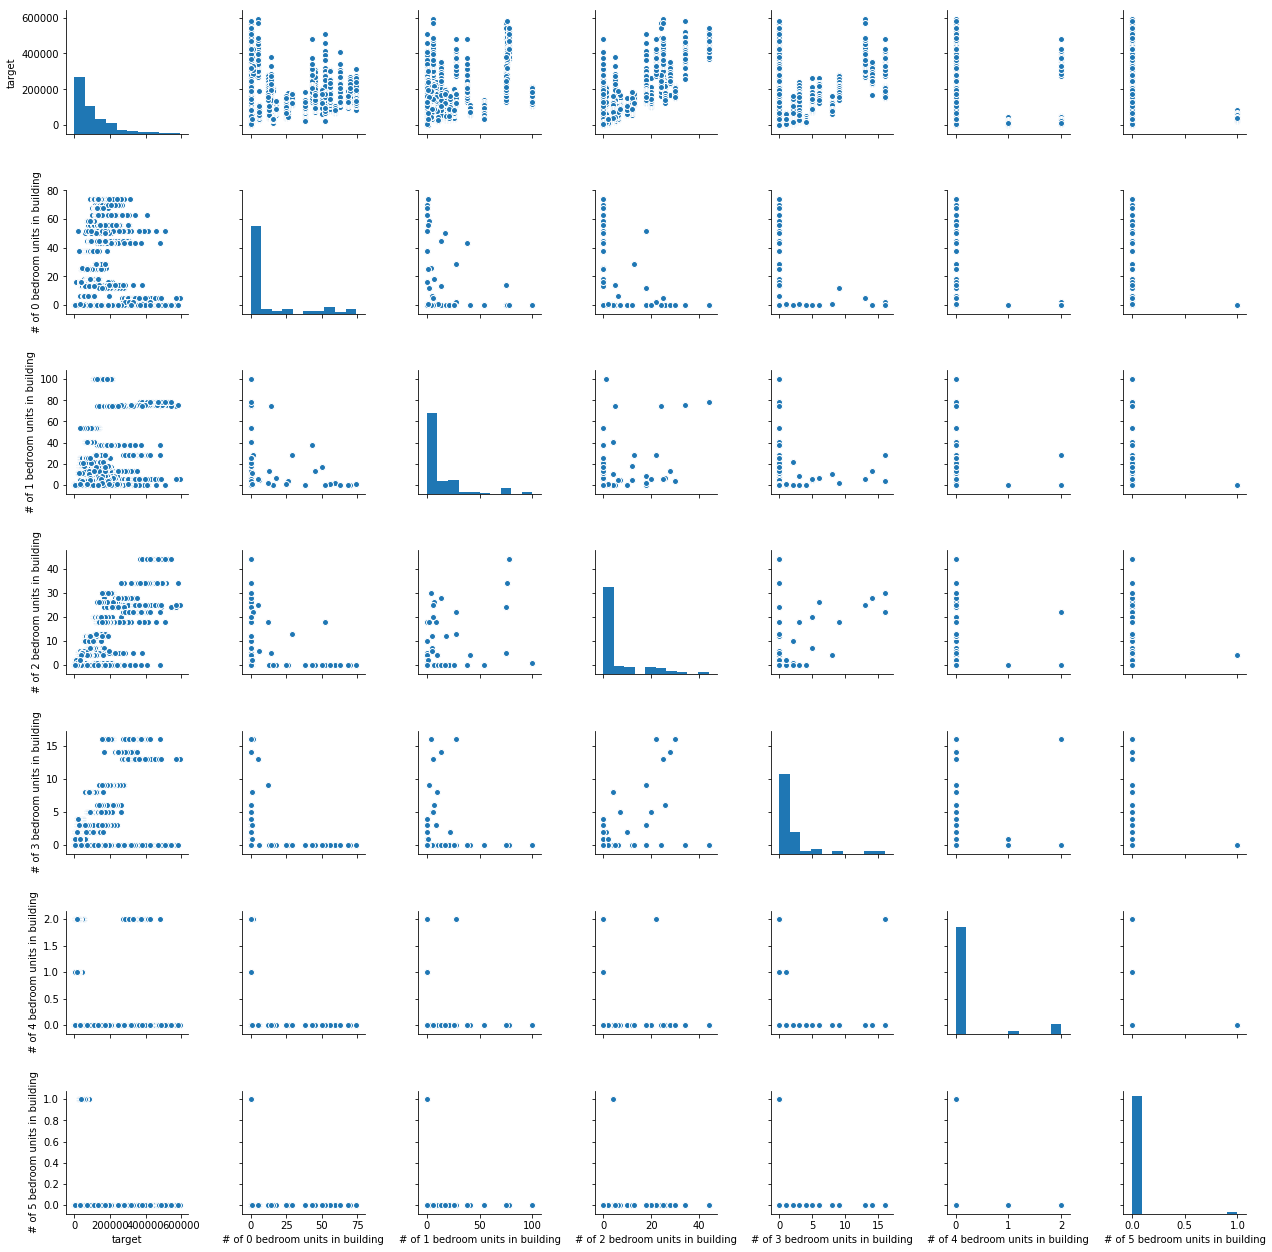

In [12]:
grp1 = [i for i in numerical.columns.tolist()[10:16] if i not in ['year', 'target']]
grp1.insert(0, 'target')
p = sns.pairplot(numerical[grp1])

## Pairplots for Number of Bedrooms * Days/Month

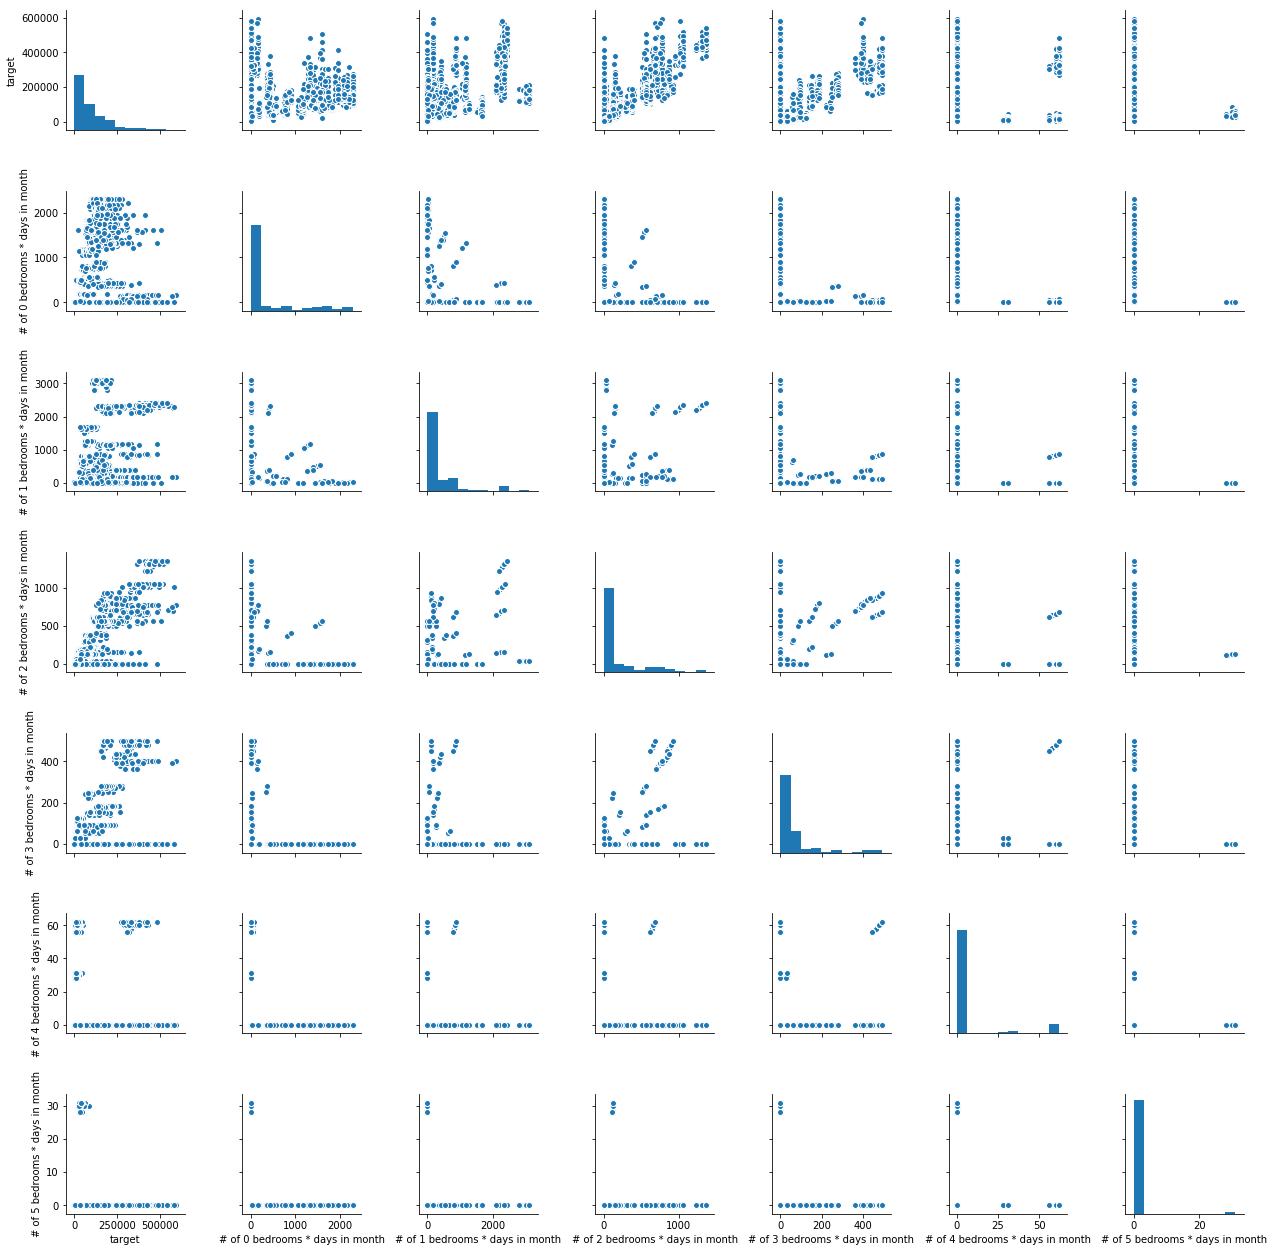

In [13]:
grp1 = [i for i in numerical.columns.tolist()[21:27] if i not in ['year', 'target']]
grp1.insert(0, 'target')
sns.pairplot(numerical[grp1])
plt.show()

# Pairplots for Number of Bedrooms - Days Vacant

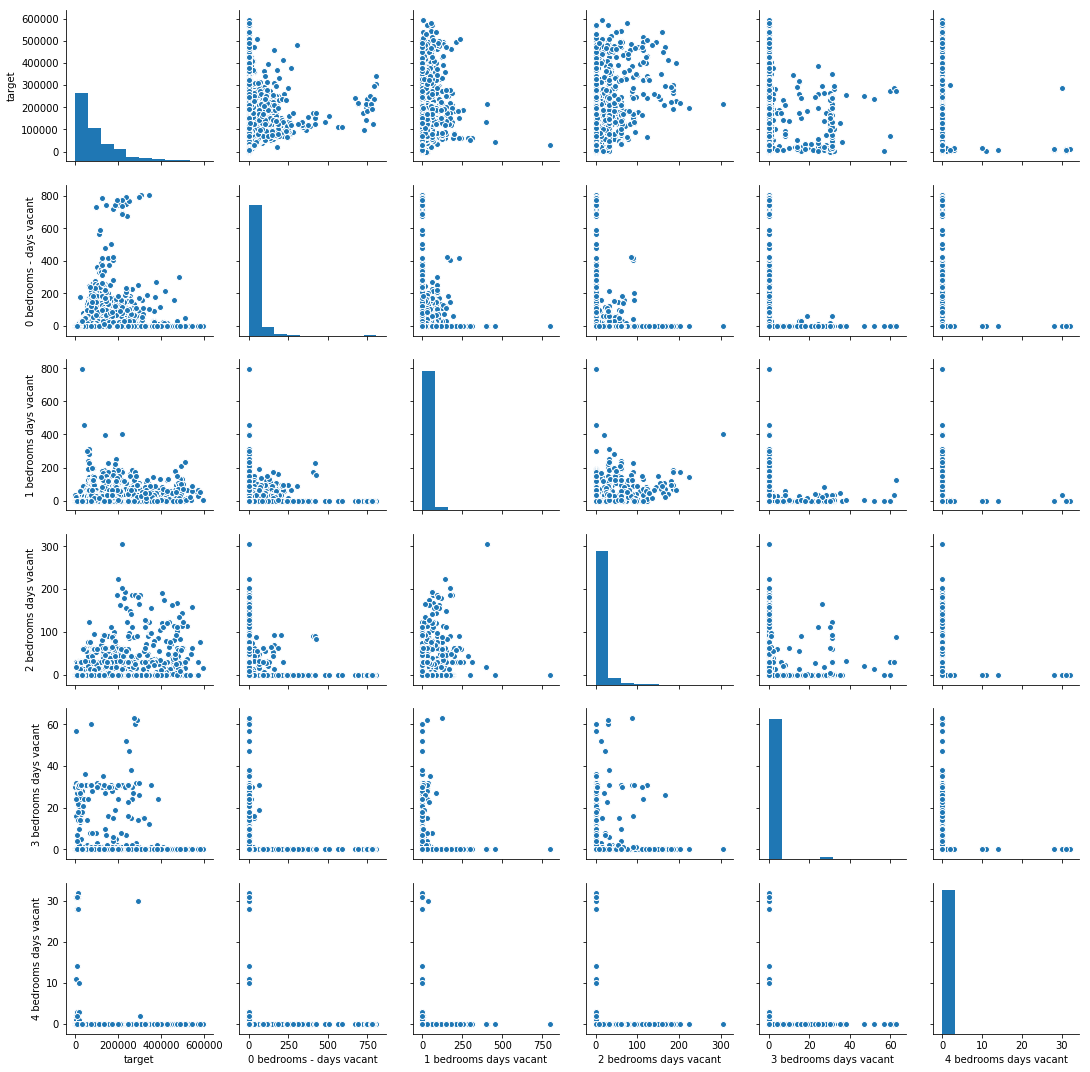

In [14]:
grp1 = [i for i in numerical.columns.tolist()[16:21] if i not in ['year', 'target']]
grp1.insert(0, 'target')
sns.pairplot(numerical[grp1])
plt.show()

## Pairplots for Number of Bedroom - Vacant Units

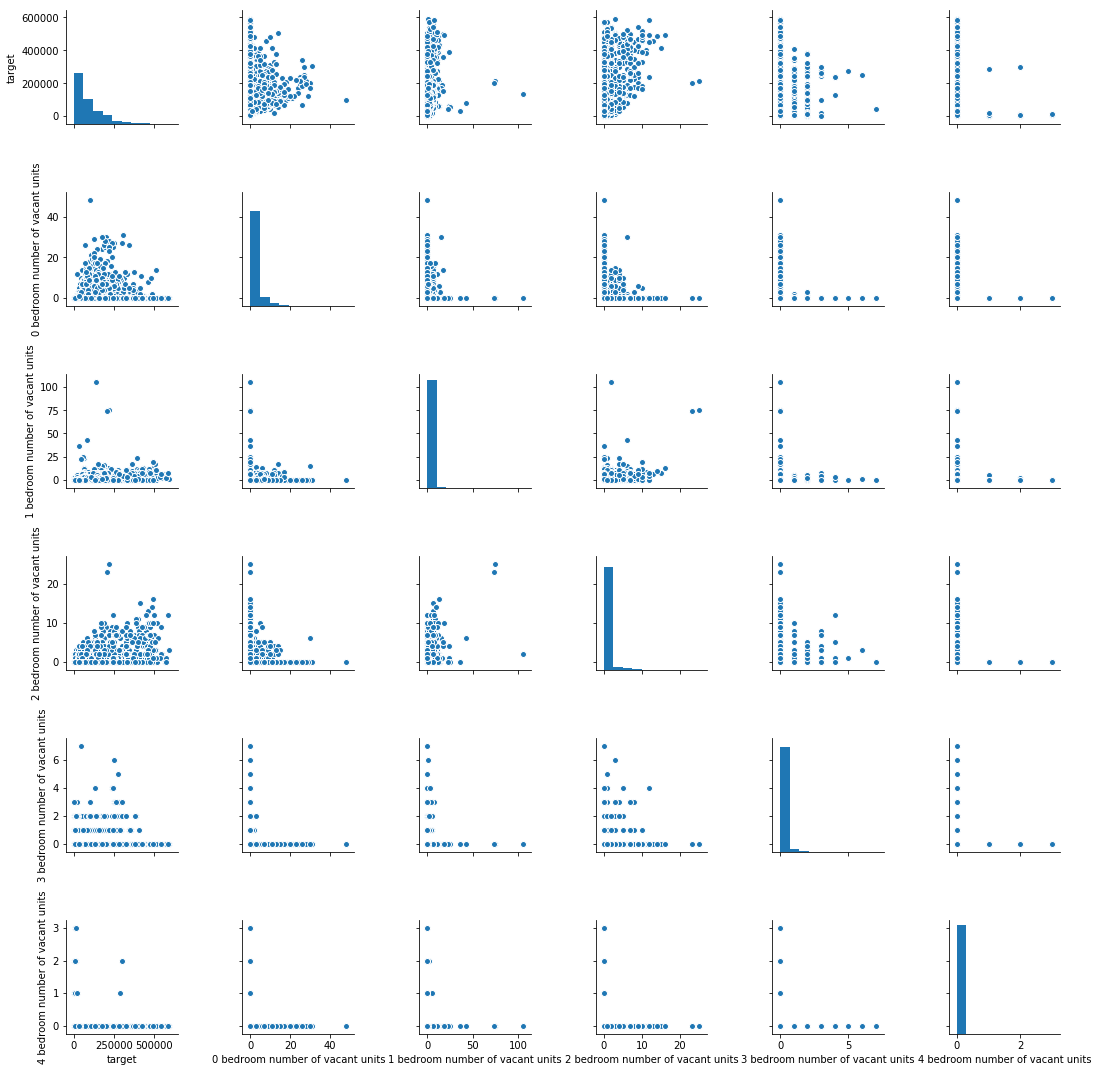

In [15]:
grp1 = [i for i in numerical.columns.tolist()[33:38] if i not in ['year', 'target']]
grp1.insert(0, 'target')
sns.pairplot(numerical[grp1])
plt.show()

##  Correlation Matrix Of Kept Variables

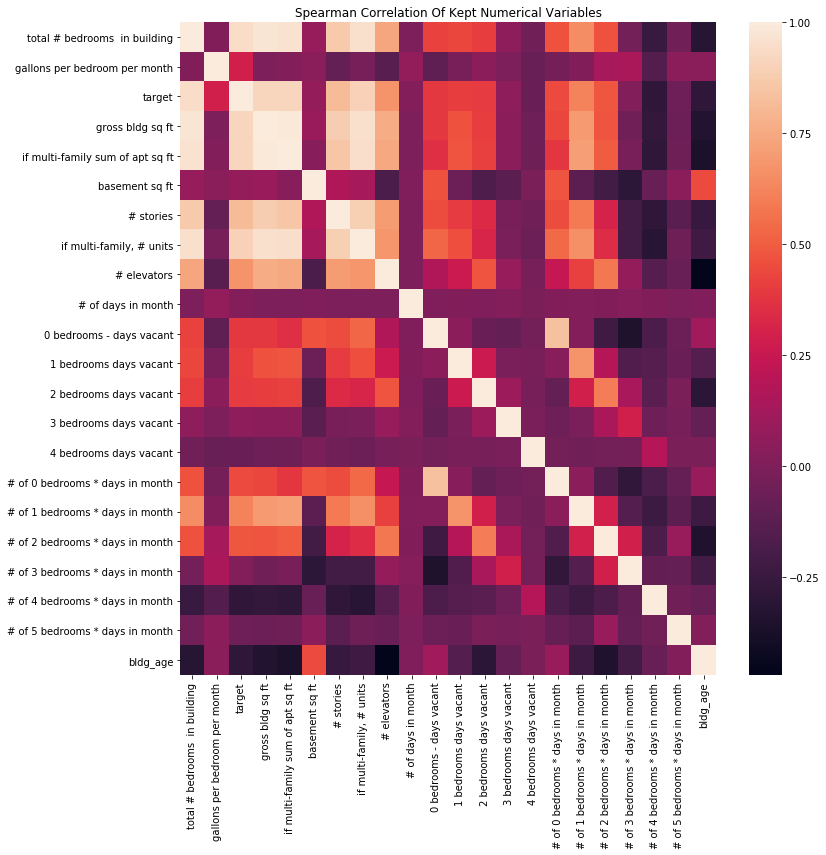

In [16]:
# Numerical Columns To Keep For Exploratory Analysis
cols=numerical.columns.tolist()
keep = cols[:10] + cols[16:27] + cols[38:]
keepnum_df = numerical[keep]
corrs = keepnum_df.corr(method='spearman')
plt.subplots(figsize=(12,12))
plt.title('Spearman Correlation Of Kept Numerical Variables')
sns.heatmap(corrs)
plt.show()

# Exploratory Analysis Of Categoricals

In [17]:
cats = df.loc[:, df.dtypes == 'object']
cats = pd.concat([cats[col].astype(str).str.lower() for col in cats.columns], axis=1)
cats.head()

yardi building name                match building name  \
0                               1822 park                          1822 park   
1     alliance addition 730 17th st south  alliance addition-730 17th street   
2  archdale apartments 1600 south 1st ave                           archdale   
3        barnabas apartments 906 7th st s                       st. barnabas   
4           buri manor 1515 chicago ave s                         buri manor   

    month  year month start date year built/gut rehabbed single family?  \
0  august  2017      august 2017                    1916             no   
1  august  2017      august 2017                    1900             no   
2  august  2017      august 2017                    1919             no   
3  august  2017      august 2017                    2005             no   
4  august  2017      august 2017                    1986             no   

  single family building type low-income housing predominant resident type  \
0                           0                yes                mixed/none   
1                           0                yes                mixed/none   
2                           0                yes                mixed/none   
3                           0                yes                mixed/none   
4                           0                yes                mixed/none   

  type of construction is there a basement? is basement finished & heated?  \
0              masonry                  yes                            yes   
1  wood or steel frame                  yes                            yes   
2              masonry                  yes                            yes   
3              masonry                  yes                            yes   
4  wood or steel frame                   no                             no   

  environmental certification if environmental certification: type  \
0                          no                                    0   
1                         yes                       leed, platinum   
2                          no                                    0   
3                          no                                    0   
4                          no                                    0   

  heating fuel          heating system hot water system fuel  \
0  natural gas          boiler (steam)           natural gas   
1  electricity  heat pump (air-source)           electricity   
2  natural gas          boiler (steam)           natural gas   
3  natural gas      boiler (hot water)           natural gas   
4  electricity      electric baseboard           electricity   

                                  hot water system  \
0                                            other   
1                 stand-alone storage water heater   
2                 stand-alone storage water heater   
3  indirect hot water tank off boiler (heat & dhw)   
4                 stand-alone storage water heater   

                           cooling system common laundry facilities  \
0                              window ac                        yes   
1  ducted central ac (outdoor condenser)                        yes   
2                              window ac                        yes   
3  ducted central ac (outdoor condenser)                        yes   
4                              window ac                        yes   

  if common laundry, dryer fuel  
0                   natural gas  
1                   natural gas  
2                   natural gas  
3                   natural gas  
4                   natural gas

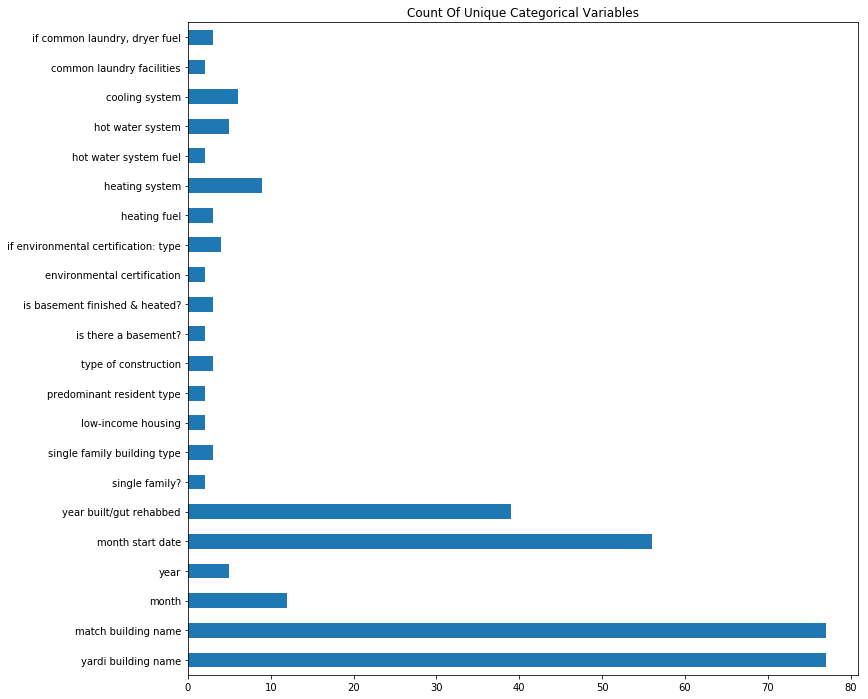

In [18]:
summary = cats.describe()
summary.loc['unique', :].plot(kind='barh', figsize=(12,12))
plt.title('Count Of Unique Categorical Variables')

In [19]:
summary

yardi building name match building name month  year  \
count                                 4282                4282  4282  4282   
unique                                  77                  77    12     5   
top     the hope block 2023 portland ave s        elliot court   may  2016   
freq                                    56                  56   384   924   

       month start date year built/gut rehabbed single family?  \
count              4282                    4282           4282   
unique               56                      39              2   
top      september 2015                    1900             no   
freq                 77                     672           3946   

       single family building type low-income housing  \
count                         4282               4282   
unique                           3                  2   
top                              0                yes   
freq                          2658               3725   

       predominant resident type type of construction is there a basement?  \
count                       4282                 4282                 4282   
unique                         2                    3                    2   
top                   mixed/none  wood or steel frame                  yes   
freq                        4077                 3446                 2968   

       is basement finished & heated? environmental certification  \
count                            4282                        4282   
unique                              3                           2   
top                               yes                          no   
freq                             3024                        3725   

       if environmental certification: type heating fuel heating system  \
count                                  4282         4282           4282   
unique                                    4            3              9   
top                                       0  natural gas        furnace   
freq                                   3725         3946           1512   

       hot water system fuel                  hot water system cooling system  \
count                   4282                              4282           4282   
unique                     2                                 5              6   
top              natural gas  stand-alone storage water heater     window ac    
freq                    4170                              3187           2072   

       common laundry facilities if common laundry, dryer fuel  
count                       4282                          4282  
unique                         2                             3  
top                          yes                   natural gas  
freq                        3834                          3778

In [20]:
cols = cats.columns.tolist()
keepcats = cols[1:4]+cols[6:]
cats = cats[keepcats]
cats.head()

match building name   month  year single family?  \
0                          1822 park  august  2017             no   
1  alliance addition-730 17th street  august  2017             no   
2                           archdale  august  2017             no   
3                       st. barnabas  august  2017             no   
4                         buri manor  august  2017             no   

  single family building type low-income housing predominant resident type  \
0                           0                yes                mixed/none   
1                           0                yes                mixed/none   
2                           0                yes                mixed/none   
3                           0                yes                mixed/none   
4                           0                yes                mixed/none   

  type of construction is there a basement? is basement finished & heated?  \
0              masonry                  yes                            yes   
1  wood or steel frame                  yes                            yes   
2              masonry                  yes                            yes   
3              masonry                  yes                            yes   
4  wood or steel frame                   no                             no   

  environmental certification if environmental certification: type  \
0                          no                                    0   
1                         yes                       leed, platinum   
2                          no                                    0   
3                          no                                    0   
4                          no                                    0   

  heating fuel          heating system hot water system fuel  \
0  natural gas          boiler (steam)           natural gas   
1  electricity  heat pump (air-source)           electricity   
2  natural gas          boiler (steam)           natural gas   
3  natural gas      boiler (hot water)           natural gas   
4  electricity      electric baseboard           electricity   

                                  hot water system  \
0                                            other   
1                 stand-alone storage water heater   
2                 stand-alone storage water heater   
3  indirect hot water tank off boiler (heat & dhw)   
4                 stand-alone storage water heater   

                           cooling system common laundry facilities  \
0                              window ac                        yes   
1  ducted central ac (outdoor condenser)                        yes   
2                              window ac                        yes   
3  ducted central ac (outdoor condenser)                        yes   
4                              window ac                        yes   

  if common laundry, dryer fuel  
0                   natural gas  
1                   natural gas  
2                   natural gas  
3                   natural gas  
4                   natural gas

In [21]:
counts = [cats[i].value_counts() for i in cats.columns]
for c in counts:
    print(c)

elliot court                           56
phillips-1513 22nd                     56
phillips-2800-2802 portland            56
chicago ave-1500                       56
paige hall                             56
phillips-2812-2814 portland            56
hope block-2115portland                56
phillips-2217 bloomington              56
phillips-2305 portland                 56
hope block ii                          56
chicago ave-1504                       56
lamoreaux (ohp+exp)                    56
hope block-2026oakland                 56
phillips-2200 bloomington              56
cvc                                    56
1822 park                              56
como by the lake 901 east como blvd    56
phillips-2714 chicago sublease         56
renaissance box                        56
phillips-2217 portland                 56
st. barnabas                           56
phillips-2805 cedar                    56
barrington                             56
phillips-2320-2322 bloomington    

In [22]:
## This is cleaning up mislabeled categorical variables
cats['single family?'].loc[cats['single family?'] == '0'] = 'no'
cats['type of construction'].loc[cats['type of construction'].str.contains('masonry')] = 'masonry'
cats['is there a basement?'].loc[cats['is there a basement?'] == '0'] = 'no'
cats['if environmental certification: type'].loc[cats['if environmental certification: type']=='0']='no'
cats['hot water system'].loc[cats['hot water system']=='0'] = 'no'
cats['is basement finished & heated?'].loc[cats['is basement finished & heated?']=='0']='no'

In [23]:
cats.describe()

match building name month  year single family?  \
count                 4282  4282  4282           4282   
unique                  77    12     5              2   
top           elliot court   may  2016             no   
freq                    56   384   924           3946   

       single family building type low-income housing  \
count                         4282               4282   
unique                           3                  2   
top                              0                yes   
freq                          2658               3725   

       predominant resident type type of construction is there a basement?  \
count                       4282                 4282                 4282   
unique                         2                    2                    2   
top                   mixed/none  wood or steel frame                  yes   
freq                        4077                 3446                 2968   

       is basement finished & heated? environmental certification  \
count                            4282                        4282   
unique                              2                           2   
top                               yes                          no   
freq                             3024                        3725   

       if environmental certification: type heating fuel heating system  \
count                                  4282         4282           4282   
unique                                    4            3              9   
top                                      no  natural gas        furnace   
freq                                   3725         3946           1512   

       hot water system fuel                  hot water system cooling system  \
count                   4282                              4282           4282   
unique                     2                                 5              6   
top              natural gas  stand-alone storage water heater     window ac    
freq                    4170                              3187           2072   

       common laundry facilities if common laundry, dryer fuel  
count                       4282                          4282  
unique                         2                             3  
top                          yes                   natural gas  
freq                        3834                          3778

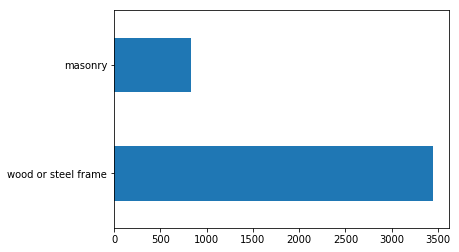

In [24]:
cats['type of construction'].value_counts().plot(kind='barh')

In [25]:
cats = cats.drop('year', axis=1)

In [26]:
out2 = pd.concat([df['match building name'], cats, keepnum_df], axis=1)

In [27]:
out2.to_csv('cleaned_df3.csv', index=False, encoding='utf-8')

# Creation Of Model

In [59]:
df = pd.read_csv('cleaned_df3.csv')
df = df.drop('gallons per bedroom per month', axis=1)
df.head()

match building name              match building name.1  \
0                          1822 Park                          1822 park   
1  Alliance Addition-730 17th Street  alliance addition-730 17th street   
2                           Archdale                           archdale   
3                       St. Barnabas                       st. barnabas   
4                         Buri Manor                         buri manor   

    month single family? single family building type low-income housing  \
0  august             no                           0                yes   
1  august             no                           0                yes   
2  august             no                           0                yes   
3  august             no                           0                yes   
4  august             no                           0                yes   

  predominant resident type type of construction is there a basement?  \
0                mixed/none              masonry                  yes   
1                mixed/none  wood or steel frame                  yes   
2                mixed/none              masonry                  yes   
3                mixed/none              masonry                  yes   
4                mixed/none  wood or steel frame                   no   

  is basement finished & heated? environmental certification  \
0                            yes                          no   
1                            yes                         yes   
2                            yes                          no   
3                            yes                          no   
4                             no                          no   

  if environmental certification: type heating fuel          heating system  \
0                                   no  natural gas          boiler (steam)   
1                       leed, platinum  electricity  heat pump (air-source)   
2                                   no  natural gas          boiler (steam)   
3                                   no  natural gas      boiler (hot water)   
4                                   no  electricity      electric baseboard   

  hot water system fuel                                 hot water system  \
0           natural gas                                            other   
1           electricity                 stand-alone storage water heater   
2           natural gas                 stand-alone storage water heater   
3           natural gas  indirect hot water tank off boiler (heat & dhw)   
4           electricity                 stand-alone storage water heater   

                           cooling system common laundry facilities  \
0                              window ac                        yes   
1  ducted central ac (outdoor condenser)                        yes   
2                              window ac                        yes   
3  ducted central ac (outdoor condenser)                        yes   
4                              window ac                        yes   

  if common laundry, dryer fuel  total # bedrooms  in building       target  \
0                   natural gas                             18   30862.9998   
1                   natural gas                             61   78751.0000   
2                   natural gas                             30  117300.0000   
3                   natural gas                             52   88704.6004   
4                   natural gas                             38   63680.7990   

   gross bldg sq ft  if multi-family sum of apt sq ft  basement sq ft  \
0           18000.0                              9772            4500   
1           33124.0                             20790            7126   
2           19760.0                             12178            4940   
3           32467.0                             17316            6839   
4           16464.0                              9970               0   

   # stories  if m

In [60]:
cols = df.columns.tolist()
cols = [col for col in cols if not col.endswith('.1')]
df = df[cols]

In [61]:
df.columns.tolist()

['match building name',
 'month',
 'single family?',
 'single family building type',
 'low-income housing',
 'predominant resident type',
 'type of construction',
 'is there a basement?',
 'is basement finished & heated?',
 'environmental certification',
 'if environmental certification: type',
 'heating fuel',
 'heating system',
 'hot water system fuel',
 'hot water system',
 'cooling system',
 'common laundry facilities',
 'if common laundry, dryer fuel',
 'total # bedrooms  in building',
 'target',
 'gross bldg sq ft',
 'if multi-family sum of apt sq ft',
 'basement sq ft',
 '# stories',
 'if multi-family, # units',
 '# elevators',
 '# of days in month',
 '0 bedrooms - days vacant',
 '1 bedrooms days vacant',
 '2 bedrooms days vacant',
 '3 bedrooms days vacant',
 '4 bedrooms days vacant',
 '# of 0 bedrooms * days in month',
 '# of 1 bedrooms * days in month',
 '# of 2 bedrooms * days in month',
 '# of 3 bedrooms * days in month',
 '# of 4 bedrooms * days in month',
 '# of 5 bedrooms

In [62]:
df = df.rename(columns={'match building name': 'building'})
#df = df.drop('match building name.1', axis=1)

In [63]:
df.head()

building   month single family?  \
0                          1822 Park  august             no   
1  Alliance Addition-730 17th Street  august             no   
2                           Archdale  august             no   
3                       St. Barnabas  august             no   
4                         Buri Manor  august             no   

  single family building type low-income housing predominant resident type  \
0                           0                yes                mixed/none   
1                           0                yes                mixed/none   
2                           0                yes                mixed/none   
3                           0                yes                mixed/none   
4                           0                yes                mixed/none   

  type of construction is there a basement? is basement finished & heated?  \
0              masonry                  yes                            yes   
1  wood or steel frame                  yes                            yes   
2              masonry                  yes                            yes   
3              masonry                  yes                            yes   
4  wood or steel frame                   no                             no   

  environmental certification if environmental certification: type  \
0                          no                                   no   
1                         yes                       leed, platinum   
2                          no                                   no   
3                          no                                   no   
4                          no                                   no   

  heating fuel          heating system hot water system fuel  \
0  natural gas          boiler (steam)           natural gas   
1  electricity  heat pump (air-source)           electricity   
2  natural gas          boiler (steam)           natural gas   
3  natural gas      boiler (hot water)           natural gas   
4  electricity      electric baseboard           electricity   

                                  hot water system  \
0                                            other   
1                 stand-alone storage water heater   
2                 stand-alone storage water heater   
3  indirect hot water tank off boiler (heat & dhw)   
4                 stand-alone storage water heater   

                           cooling system common laundry facilities  \
0                              window ac                        yes   
1  ducted central ac (outdoor condenser)                        yes   
2                              window ac                        yes   
3  ducted central ac (outdoor condenser)                        yes   
4                              window ac                        yes   

  if common laundry, dryer fuel  total # bedrooms  in building       target  \
0                   natural gas                             18   30862.9998   
1                   natural gas                             61   78751.0000   
2                   natural gas                             30  117300.0000   
3                   natural gas                             52   88704.6004   
4                   natural gas                             38   63680.7990   

   gross bldg sq ft  if multi-family sum of apt sq ft  basement sq ft  \
0           18000.0                              9772            4500   
1           33124.0                             20790            7126   
2           19760.0                             12178            4940   
3           32467.0                             17316            6839   
4           16464.0                              9970               0   

   # stories  if multi-family, # units  # elevators  # of days in month  \
0        4.0                        18            0                  31   
1        3.0                        51            1                  31   
2        3.0  

In [65]:
# Remove the building column as a label for later use
bldgs = df['building']
print('Number of unique buildings in the dataset:  {}'.format(len(set(bldgs))))
print('Drop the building labels from both datasets...')
df = df.drop(['building'], axis=1)

Number of unique buildings in the dataset:  77
Drop the building labels from both datasets...


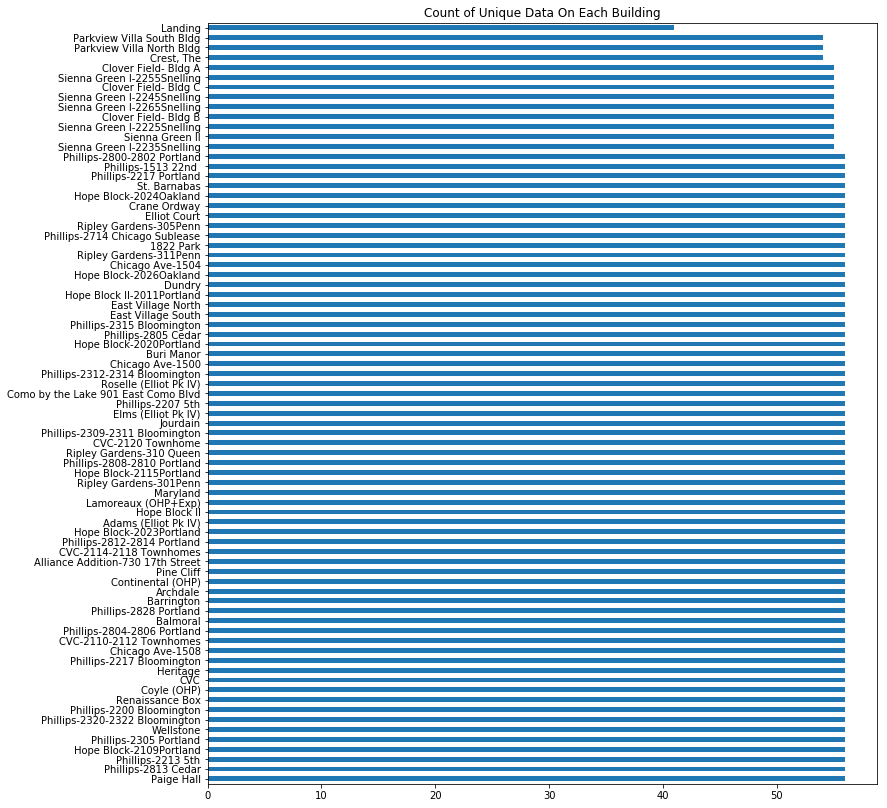

In [66]:
bldgs.value_counts().plot(kind='barh', figsize=(12,14))
plt.title('Count of Unique Data On Each Building')

In [67]:
print('Shape of the dataframe for training:  {}'.format(df.shape))
df.head()

Shape of the dataframe for training:  (4282, 38)


month single family? single family building type low-income housing  \
0  august             no                           0                yes   
1  august             no                           0                yes   
2  august             no                           0                yes   
3  august             no                           0                yes   
4  august             no                           0                yes   

  predominant resident type type of construction is there a basement?  \
0                mixed/none              masonry                  yes   
1                mixed/none  wood or steel frame                  yes   
2                mixed/none              masonry                  yes   
3                mixed/none              masonry                  yes   
4                mixed/none  wood or steel frame                   no   

  is basement finished & heated? environmental certification  \
0                            yes                          no   
1                            yes                         yes   
2                            yes                          no   
3                            yes                          no   
4                             no                          no   

  if environmental certification: type heating fuel          heating system  \
0                                   no  natural gas          boiler (steam)   
1                       leed, platinum  electricity  heat pump (air-source)   
2                                   no  natural gas          boiler (steam)   
3                                   no  natural gas      boiler (hot water)   
4                                   no  electricity      electric baseboard   

  hot water system fuel                                 hot water system  \
0           natural gas                                            other   
1           electricity                 stand-alone storage water heater   
2           natural gas                 stand-alone storage water heater   
3           natural gas  indirect hot water tank off boiler (heat & dhw)   
4           electricity                 stand-alone storage water heater   

                           cooling system common laundry facilities  \
0                              window ac                        yes   
1  ducted central ac (outdoor condenser)                        yes   
2                              window ac                        yes   
3  ducted central ac (outdoor condenser)                        yes   
4                              window ac                        yes   

  if common laundry, dryer fuel  total # bedrooms  in building       target  \
0                   natural gas                             18   30862.9998   
1                   natural gas                             61   78751.0000   
2                   natural gas                             30  117300.0000   
3                   natural gas                             52   88704.6004   
4                   natural gas                             38   63680.7990   

   gross bldg sq ft  if multi-family sum of apt sq ft  basement sq ft  \
0           18000.0                              9772            4500   
1           33124.0                             20790            7126   
2           19760.0                             12178            4940   
3           32467.0                             17316            6839   
4           16464.0                              9970               0   

   # stories  if multi-family, # units  # elevators  # of days in month  \
0        4.0                        18            0                  31   
1        3.0                        51            1                  31   
2        3.0                        30            0                  31   
3        5.0                        52            1                  31   
4        3.0                        38            0                  31   

   0 

In [68]:
# Need to split up the dataframes into categoricals and numericals
cats = df.loc[:, 'month':'if common laundry, dryer fuel']
nums = df.loc[:, 'total # bedrooms  in building':]
nums = nums.drop('target', axis=1)
targets = df['target'].copy()
cats.head()

month single family? single family building type low-income housing  \
0  august             no                           0                yes   
1  august             no                           0                yes   
2  august             no                           0                yes   
3  august             no                           0                yes   
4  august             no                           0                yes   

  predominant resident type type of construction is there a basement?  \
0                mixed/none              masonry                  yes   
1                mixed/none  wood or steel frame                  yes   
2                mixed/none              masonry                  yes   
3                mixed/none              masonry                  yes   
4                mixed/none  wood or steel frame                   no   

  is basement finished & heated? environmental certification  \
0                            yes                          no   
1                            yes                         yes   
2                            yes                          no   
3                            yes                          no   
4                             no                          no   

  if environmental certification: type heating fuel          heating system  \
0                                   no  natural gas          boiler (steam)   
1                       leed, platinum  electricity  heat pump (air-source)   
2                                   no  natural gas          boiler (steam)   
3                                   no  natural gas      boiler (hot water)   
4                                   no  electricity      electric baseboard   

  hot water system fuel                                 hot water system  \
0           natural gas                                            other   
1           electricity                 stand-alone storage water heater   
2           natural gas                 stand-alone storage water heater   
3           natural gas  indirect hot water tank off boiler (heat & dhw)   
4           electricity                 stand-alone storage water heater   

                           cooling system common laundry facilities  \
0                              window ac                        yes   
1  ducted central ac (outdoor condenser)                        yes   
2                              window ac                        yes   
3  ducted central ac (outdoor condenser)                        yes   
4                              window ac                        yes   

  if common laundry, dryer fuel  
0                   natural gas  
1                   natural gas  
2                   natural gas  
3                   natural gas  
4                   natural gas

In [69]:
# Numerical Variables Kept For Modeling
nums.columns.tolist()

['total # bedrooms  in building',
 'gross bldg sq ft',
 'if multi-family sum of apt sq ft',
 'basement sq ft',
 '# stories',
 'if multi-family, # units',
 '# elevators',
 '# of days in month',
 '0 bedrooms - days vacant',
 '1 bedrooms days vacant',
 '2 bedrooms days vacant',
 '3 bedrooms days vacant',
 '4 bedrooms days vacant',
 '# of 0 bedrooms * days in month',
 '# of 1 bedrooms * days in month',
 '# of 2 bedrooms * days in month',
 '# of 3 bedrooms * days in month',
 '# of 4 bedrooms * days in month',
 '# of 5 bedrooms * days in month',
 'bldg_age']

In [70]:
cats.columns.tolist()

['month',
 'single family?',
 'single family building type',
 'low-income housing',
 'predominant resident type',
 'type of construction',
 'is there a basement?',
 'is basement finished & heated?',
 'environmental certification',
 'if environmental certification: type',
 'heating fuel',
 'heating system',
 'hot water system fuel',
 'hot water system',
 'cooling system',
 'common laundry facilities',
 'if common laundry, dryer fuel']

In [71]:
cats_ = pd.get_dummies(cats)
cats_.head()

month_april  month_august  month_december  month_february  month_january  \
0            0             1               0               0              0   
1            0             1               0               0              0   
2            0             1               0               0              0   
3            0             1               0               0              0   
4            0             1               0               0              0   

   month_july  month_june  month_march  month_may  month_november  \
0           0           0            0          0               0   
1           0           0            0          0               0   
2           0           0            0          0               0   
3           0           0            0          0               0   
4           0           0            0          0               0   

   month_october  month_september  single family?_no  single family?_yes  \
0              0                0                  1                   0   
1              0                0                  1                   0   
2              0                0                  1                   0   
3              0                0                  1                   0   
4              0                0                  1                   0   

   single family building type_0  single family building type_detached   \
0                              1                                      0   
1                              1                                      0   
2                              1                                      0   
3                              1                                      0   
4                              1                                      0   

   single family building type_shared wall   low-income housing_no  \
0                                         0                      0   
1                                         0                      0   
2                                         0                      0   
3                                         0                      0   
4                                         0                      0   

   low-income housing_yes  predominant resident type_elderly  \
0                       1                                  0   
1                       1                                  0   
2                       1                                  0   
3                       1                                  0   
4                       1                                  0   

   predominant resident type_mixed/none  type of construction_masonry  \
0                                     1                             1   
1                                     1                             0   
2                                     1                             1   
3                                     1                             1   
4                                     1                             0   

   type of construction_wood or steel frame  is there a basement?_no  \
0                                         0                        0   
1                                         1                        0   
2                                         0                        0   
3                                         0                        0   
4                                         1                        1   

   is there a basement?_yes  is basement finished & heated?_no  \
0                         1                                  0   
1                         1                                  0   
2                         1                                  0   
3                         1                                  0   
4                         0                                  1   

   is basement finished & heated?_yes  environmental certification_no  \
0                                   1                    

In [72]:
# Concatenate the targets, the buildings, the categorical variables, and the numerical variables, then create a validation set which should be dropped from the training dataset
X_df = pd.concat([ bldgs, targets, cats_, nums], axis=1)
print(X_df['target'].describe())
print('Size of the dataset:  {}'.format(X_df.shape))
valid_set = X_df.sample(frac=0.2)
print('Size of the validation set:  {}'.format(valid_set.shape))
print('Dropping the validation samples...')
X_df = X_df.loc[~X_df.index.isin(valid_set.index)].copy()
print('Size of the new training set is:  {}'.format(X_df.shape))

count      4282.000000
mean      97258.865249
std      101705.207525
min           0.000000
25%       21234.975000
50%       66724.349800
75%      137072.730000
max      592877.000000
Name: target, dtype: float64
Size of the dataset:  (4282, 85)
Size of the validation set:  (856, 85)
Dropping the validation samples...
Size of the new training set is:  (3426, 85)


/Users/Greg/anaconda/envs/main/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


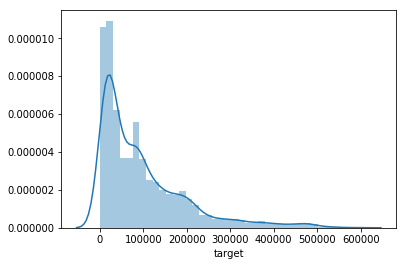

In [73]:
sns.distplot(X_df['target'])

In [74]:
def create_dsets(df):
    target = df['target'].values
    bldgs = df['building'].tolist()
    X = df.drop(['target', 'building'], axis=1)
    features = X.columns.tolist()
    X = X.values
    return X, target, bldgs, features

In [75]:
def makeplot(estimator, X, y, X_valid, y_valid, title):#, score, mse=None, mae=None):
    predicted = estimator.predict(X)
    pred_valid = estimator.predict(X_valid)
    
    score = "Training R2 Score:  {}".format(estimator.score(X, y))
    score2 = "Validation R2 Score:  {}".format(estimator.score(X_valid, y_valid))

    mse = "Training MSE:  {}".format(mean_squared_error(y1, estimator.predict(X)))
    mse2 = "Validation MSE:  {}".format(mean_squared_error(y_valid, estimator.predict(X_valid)))

    mae = 'Training Median Absolute Error is:  {}'.format(median_absolute_error(y, estimator.predict(X)))
    mae2 = 'Validation Median Absolute Error is:  {}'.format(median_absolute_error(y_valid, estimator.predict(X_valid)))

    plt.figure(figsize=(15,9))
    plt.title(title)
    
    plt.scatter(y, y)
    plt.scatter(y, predicted, edgecolors='red', facecolors='none')
    plt.scatter(y_valid, pred_valid, edgecolors='green', facecolors='green')
    
    plt.annotate(score, xy=(0.05, .86), xycoords='axes fraction')
    plt.annotate(score2, xy=(.05, .84), xycoords='axes fraction')
    
    plt.annotate(mse, xy=(.05, .82), xycoords='axes fraction')
    plt.annotate(mse2, xy=(.05, .80), xycoords='axes fraction')


    plt.annotate(mae, xy=(.05, .78), xycoords='axes fraction')
    plt.annotate(mae2, xy=(.05, .76), xycoords='axes fraction')


    plt.annotate('Blue = Actual', xy=(.05, .90), xycoords='axes fraction')
    plt.annotate('Red = Predicted', xy=(.05, .88), xycoords='axes fraction')
    plt.annotate('Green = Validation', xy=(0.05, 0.92), xycoords='axes fraction')
    
    plt.xlabel('Actual Water Consumption per Building')
    plt.ylabel('Predicted Water Consumption per Building')
    plt.show()

In [98]:
# Create the matrices for training a model, the target values, list of building names, and the featurenames for both the training data, and the validation data
X, y, bldgs, features = create_dsets(X_df)
X_valid, y_valid, bldgs_valid, _ = create_dsets(valid_set)

## Benchmark Linear Regression

Average training score is:  0.0


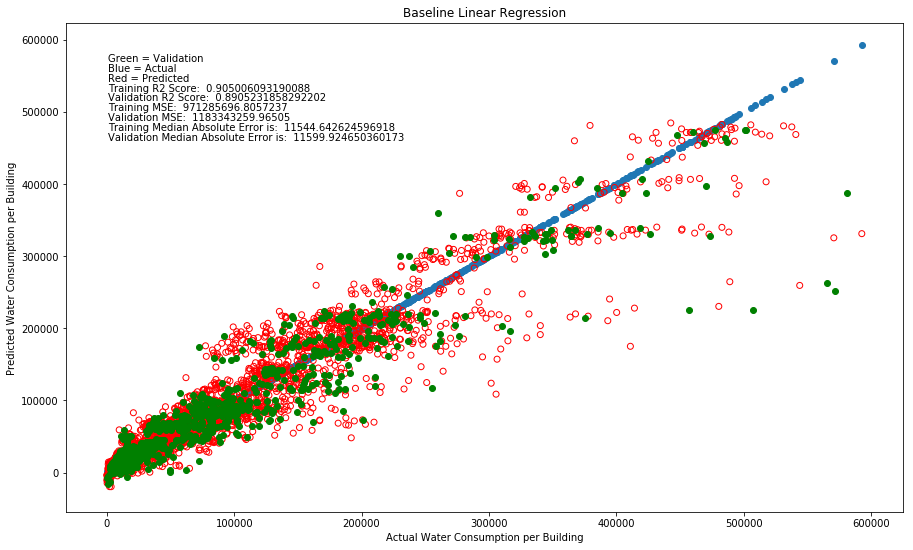

In [97]:
scores = []
lr = linear_model.LinearRegression()
loo = LeaveOneOut()
for train_idx, test_idx in loo.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    lr.fit(X_train, y_train)
    scores.append(lr.score(X_test, y_test))
print('Average training score is:  {}'.format(np.mean(scores)))
makeplot(estimator=lr, X=X, y=y, X_valid=X_valid, y_valid=y_valid, title='Baseline Linear Regression')

## Single Level Decision Tree

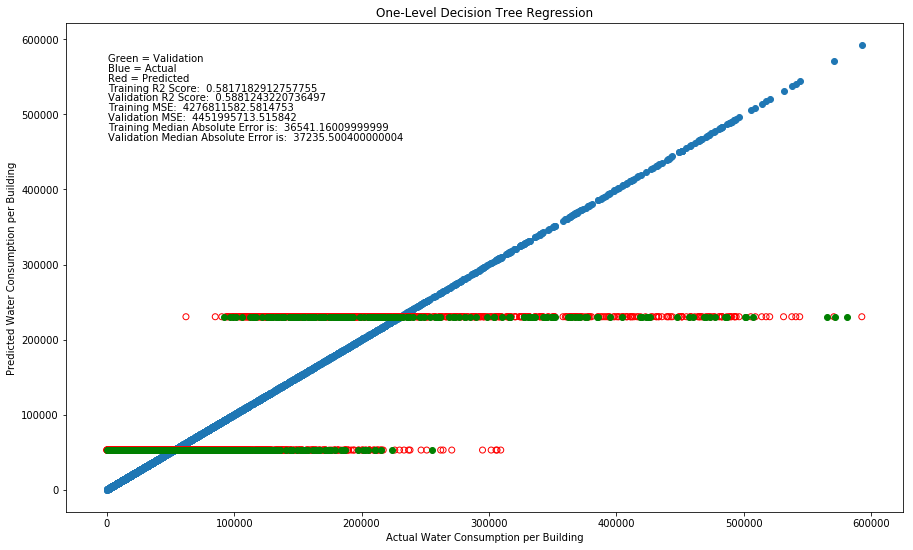

In [99]:
scores = []
clf_ = DecisionTreeRegressor(max_depth=1)
loo_ = LeaveOneOut
for train_idx, test_idx in loo.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf_.fit(X_train, y_train)
    scores.append(clf_.score(X_test, y_test))
makeplot(estimator=clf_, X=X, y=y1, 
         X_valid=X_valid, y_valid=y_valid, title='One-Level Decision Tree Regression')

## Decision Tree Regressor

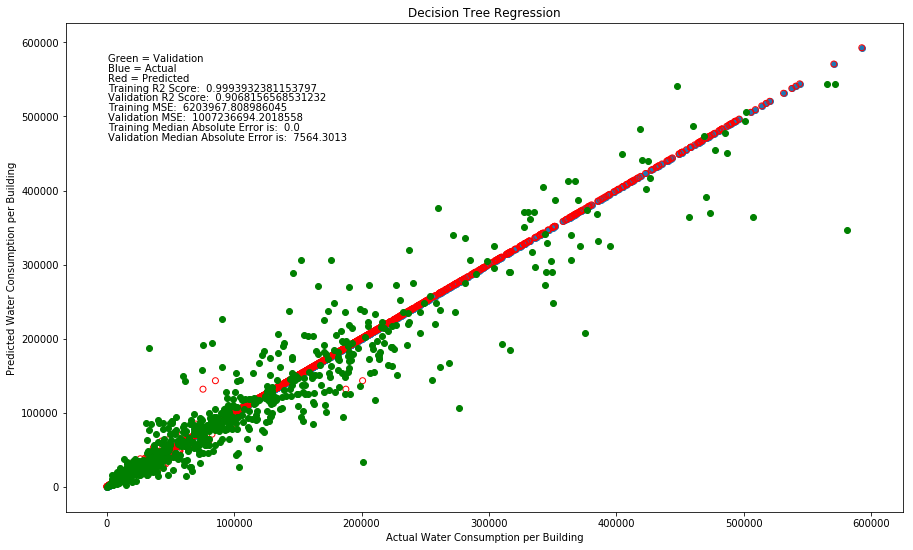

In [79]:
clf = DecisionTreeRegressor()
clf.fit(X, y1)
makeplot(estimator=clf, X=X, y=y, 
         X_valid=X_valid, y_valid=y1_valid, title='Decision Tree Regression')

## Decision Tree Trained with Leave One Out Cross-Validation

Averge model score during training is:  0.003210741389375365


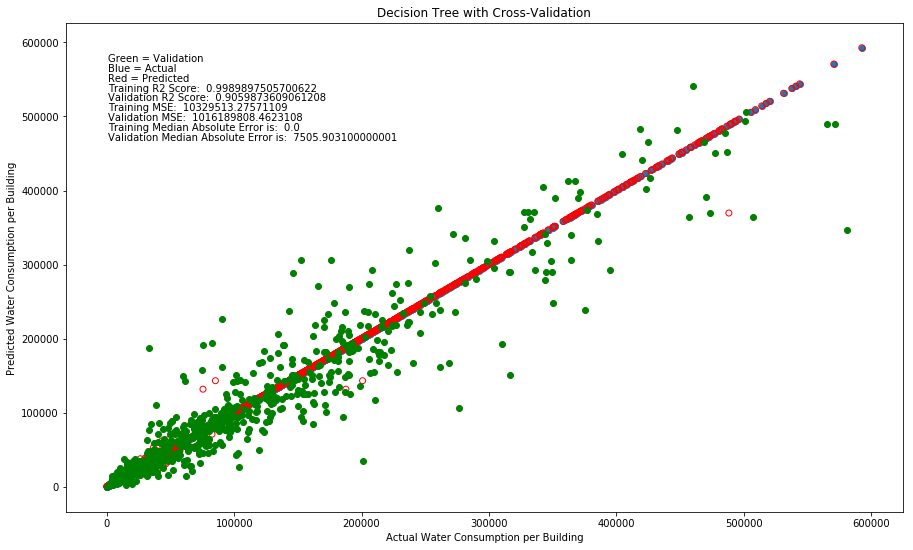

In [103]:
scores = []
clf = DecisionTreeRegressor()
loo = LeaveOneOut()
for train_idx, test_idx in loo.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print('Averge model score during training is:  {}'.format(np.mean(scores)))
makeplot(estimator=clf, X=X, y=y, X_valid=X_valid, y_valid=y_valid, title='Decision Tree with Cross-Validation')

# Decision Tree Trained With Group Shuffle-Split Cross-Validation

Number of splits during training:  7
Averge model score during training is:  0.1284866678564194


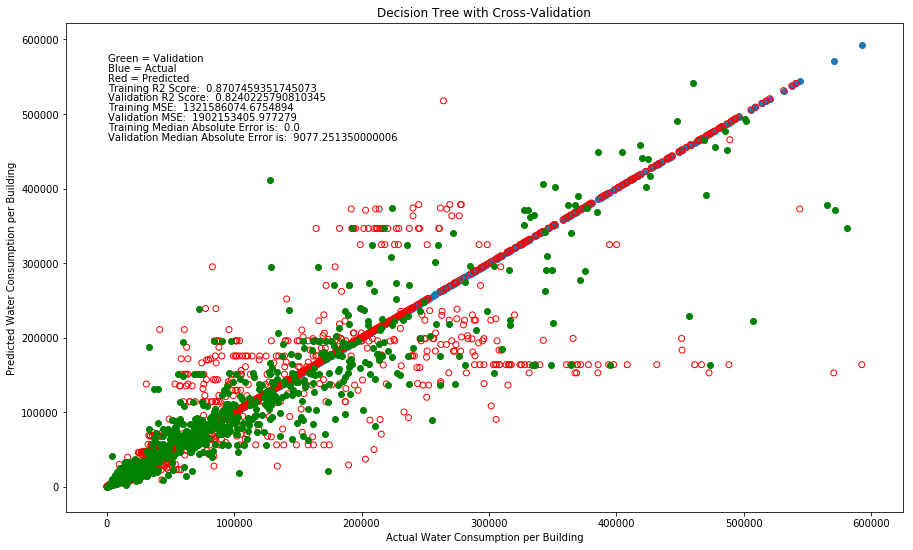

In [109]:
scores = []
clf = DecisionTreeRegressor()
gso = GroupShuffleSplit(n_splits=7)
print('Number of splits during training:  {}'.format(gso.get_n_splits(X, y, groups=bldgs)))
for train_idx, test_idx in gso.split(X, y, groups=bldgs):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print('Averge model score during training is:  {}'.format(np.mean(scores)))
makeplot(estimator=clf, X=X, y=y, X_valid=X_valid, y_valid=y_valid, title='Decision Tree with Cross-Validation')

In [80]:
# Save the trained model
joblib.dump(clf, os.path.join('trained_model.pkl'))

['trained_model.pkl']

In [91]:
clfplot=export_graphviz(clf, out_file='my_tree.dot', feature_names=features)
with open('my_tree.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

In [82]:
# Save the test data to a csv file
df_ = pd.DataFrame(data=X_valid, index=bldgs_valid, columns=features)
df_.to_csv(os.path.join('model', 'test_data.csv'), encoding='utf-8', index_label='buildings')

In [83]:
# These are the predictions on the data from the trained model...
p = pd.DataFrame(data=clf.predict(X_valid), index=bldgs_valid, columns=['Predicted Monthly Water Consumption'])
p = pd.concat([p, df_], axis=1)
p.to_csv(os.path.join('model', 'predictions_test.csv'), encoding='utf-8', index_label='buildings')


# How To Make It Consumable?

In [84]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
#    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{} if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else: if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{} return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [85]:
# For a simple model...
tree_to_code(clf_, feature_names=features)

   if total # bedrooms  in building <= 62.0:
     return [[ 52672.45668621]]
  else: if total # bedrooms  in building > 62.0
     return [[ 230676.15038298]]


In [86]:
# For the actual model
tree_to_code(clf, feature_names=features)

   if total # bedrooms  in building <= 62.0:
     if total # bedrooms  in building <= 24.0:
       if total # bedrooms  in building <= 9.5:
         if single family?_yes <= 0.5:
           if total # bedrooms  in building <= 8.5:
             if bldg_age <= 116.5:
               if single family building type_detached  <= 0.5:
                 if gross bldg sq ft <= 3505.0:
                   if 2 bedrooms days vacant <= 15.5:
                     if 2 bedrooms days vacant <= 2.0:
                       if basement sq ft <= 609.0:
                         if bldg_age <= 115.5:
                           if 3 bedrooms days vacant <= 13.5:
                             if month_december <= 0.5:
                               if bldg_age <= 13.5:
                                 if bldg_age <= 10.5:
                                   if # of 3 bedrooms * days in month <= 58.0:
                                     return [[ 10893.4998]]
                                  else: if # of 3 bed

In [57]:
# How about we create an executable instead...